In [ ]:
# 1. Import packages
import tensorflow as tf
import os
from tensorflow import keras
from tqdm import tqdm 
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt


In [ ]:
# 2. Data Loading
dataset = r"C:\Users\hariz\Desktop\Capstone4(Biomedic)\dataset\data-science-bowl-2018-2"

In [350]:
# 3. Parsing Dataset
IMG_HEIGHT = 128 
IMG_WIDTH = 128   
IMG_CHANNELS = 3

def parse_image(filename, img_height, img_width):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0,1]
    return image

def parse_mask(filename, img_height, img_width):
    mask = tf.io.read_file(filename)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [img_height, img_width])
    mask = mask / 255.0  # Normalize to [0,1]
    return mask

def load_dataset(image_dir, mask_dir, img_height, img_width, batch_size=32):
    # Get lists of image and mask file paths
    image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)])
    
    # Create TensorFlow datasets
    image_ds = tf.data.Dataset.from_tensor_slices(image_files).map(
        lambda x: parse_image(x, img_height, img_width), num_parallel_calls=tf.data.AUTOTUNE)
    mask_ds = tf.data.Dataset.from_tensor_slices(mask_files).map(
        lambda x: parse_mask(x, img_height, img_width), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Combine image and mask datasets
    dataset = tf.data.Dataset.zip((image_ds, mask_ds))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Load training and testing datasets
train_dataset= load_dataset(r'C:\Users\hariz\Desktop\Capstone4(Biomedic)\dataset\data-science-bowl-2018-2\train\inputs', r'C:\Users\hariz\Desktop\Capstone4(Biomedic)\dataset\data-science-bowl-2018-2\train\masks', IMG_HEIGHT, IMG_WIDTH)
test_dataset = load_dataset(r'C:\Users\hariz\Desktop\Capstone4(Biomedic)\dataset\data-science-bowl-2018-2\test\inputs', r'C:\Users\hariz\Desktop\Capstone4(Biomedic)\dataset\data-science-bowl-2018-2\test\masks', IMG_HEIGHT, IMG_WIDTH)


In [351]:
# 4. Create a custom augmentation layer through subclassing
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [352]:
# 5. Create a function to visualize the image, label and prediction
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

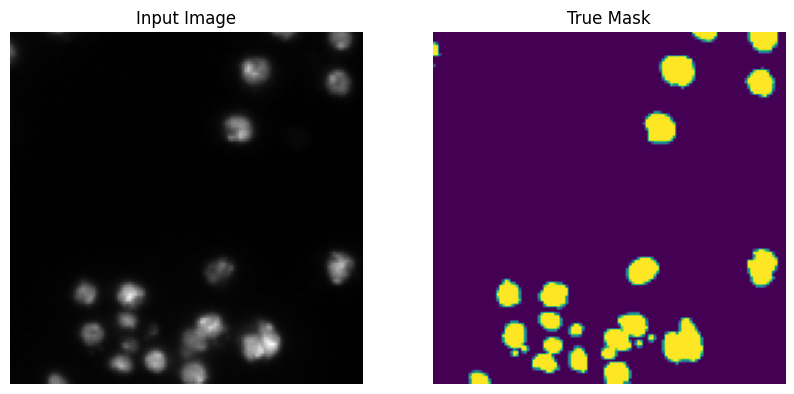

In [353]:
# 6. Let's test out the function 
for images,labels in test_dataset.take(1):
    sample_image, sample_mask = images[0],labels[0]
    display([images[0],labels[0]])

In [354]:
# 7. Check for the images shape
images[0].shape

TensorShape([128, 128, 3])

In [355]:
# 8. Model development
# (A) Get the pretrained model as feature extractor
base_model = keras.applications.MobileNetV2(input_shape=[128,128,3],
                                            include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_49[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [356]:
# 9. Use these activations layers as the outputs of the feature extractor
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extractor model that will connect to the upsampling path later
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# Freeze the feature extractor
down_stack.trainable = False

In [357]:
# Create the upsampling layers
up_stack = [ # helps to umsample once
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8 
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

up_stack[0].summary()
# seq model containing 3 layers : conv, batch, relu

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_46             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [358]:
# 10. Create a function to help construct the U-Net model 
def unet_model(output_channels:int): # want to specify what dtype to enforce
    # Use functional API to build the entire model
    # (A) Start with input
    inputs = keras.layers.Input(shape=[128,128,3])
    # (B) Followed by the feature extractor
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1]) # reversed at output to match back the numbering for upsampling
    # (C) Build the upsampling path by concatenating with the outputs from feature extractor, along with using the upsampling layers
    for up, skip in zip(up_stack, skips): # upsampling > concat(result+skip)
        x = up(x)   
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    # (D) Construct the last layer, which will be the transpose convolution layer 
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  # perform one last upsampling to restore image 64x64 -> 128x128 
# no output activation= raw number and not probability = kna careful sbb from_logits=True
    x = last(x) # change the layer

    model = keras.Model(inputs=inputs, outputs=x)

    return model

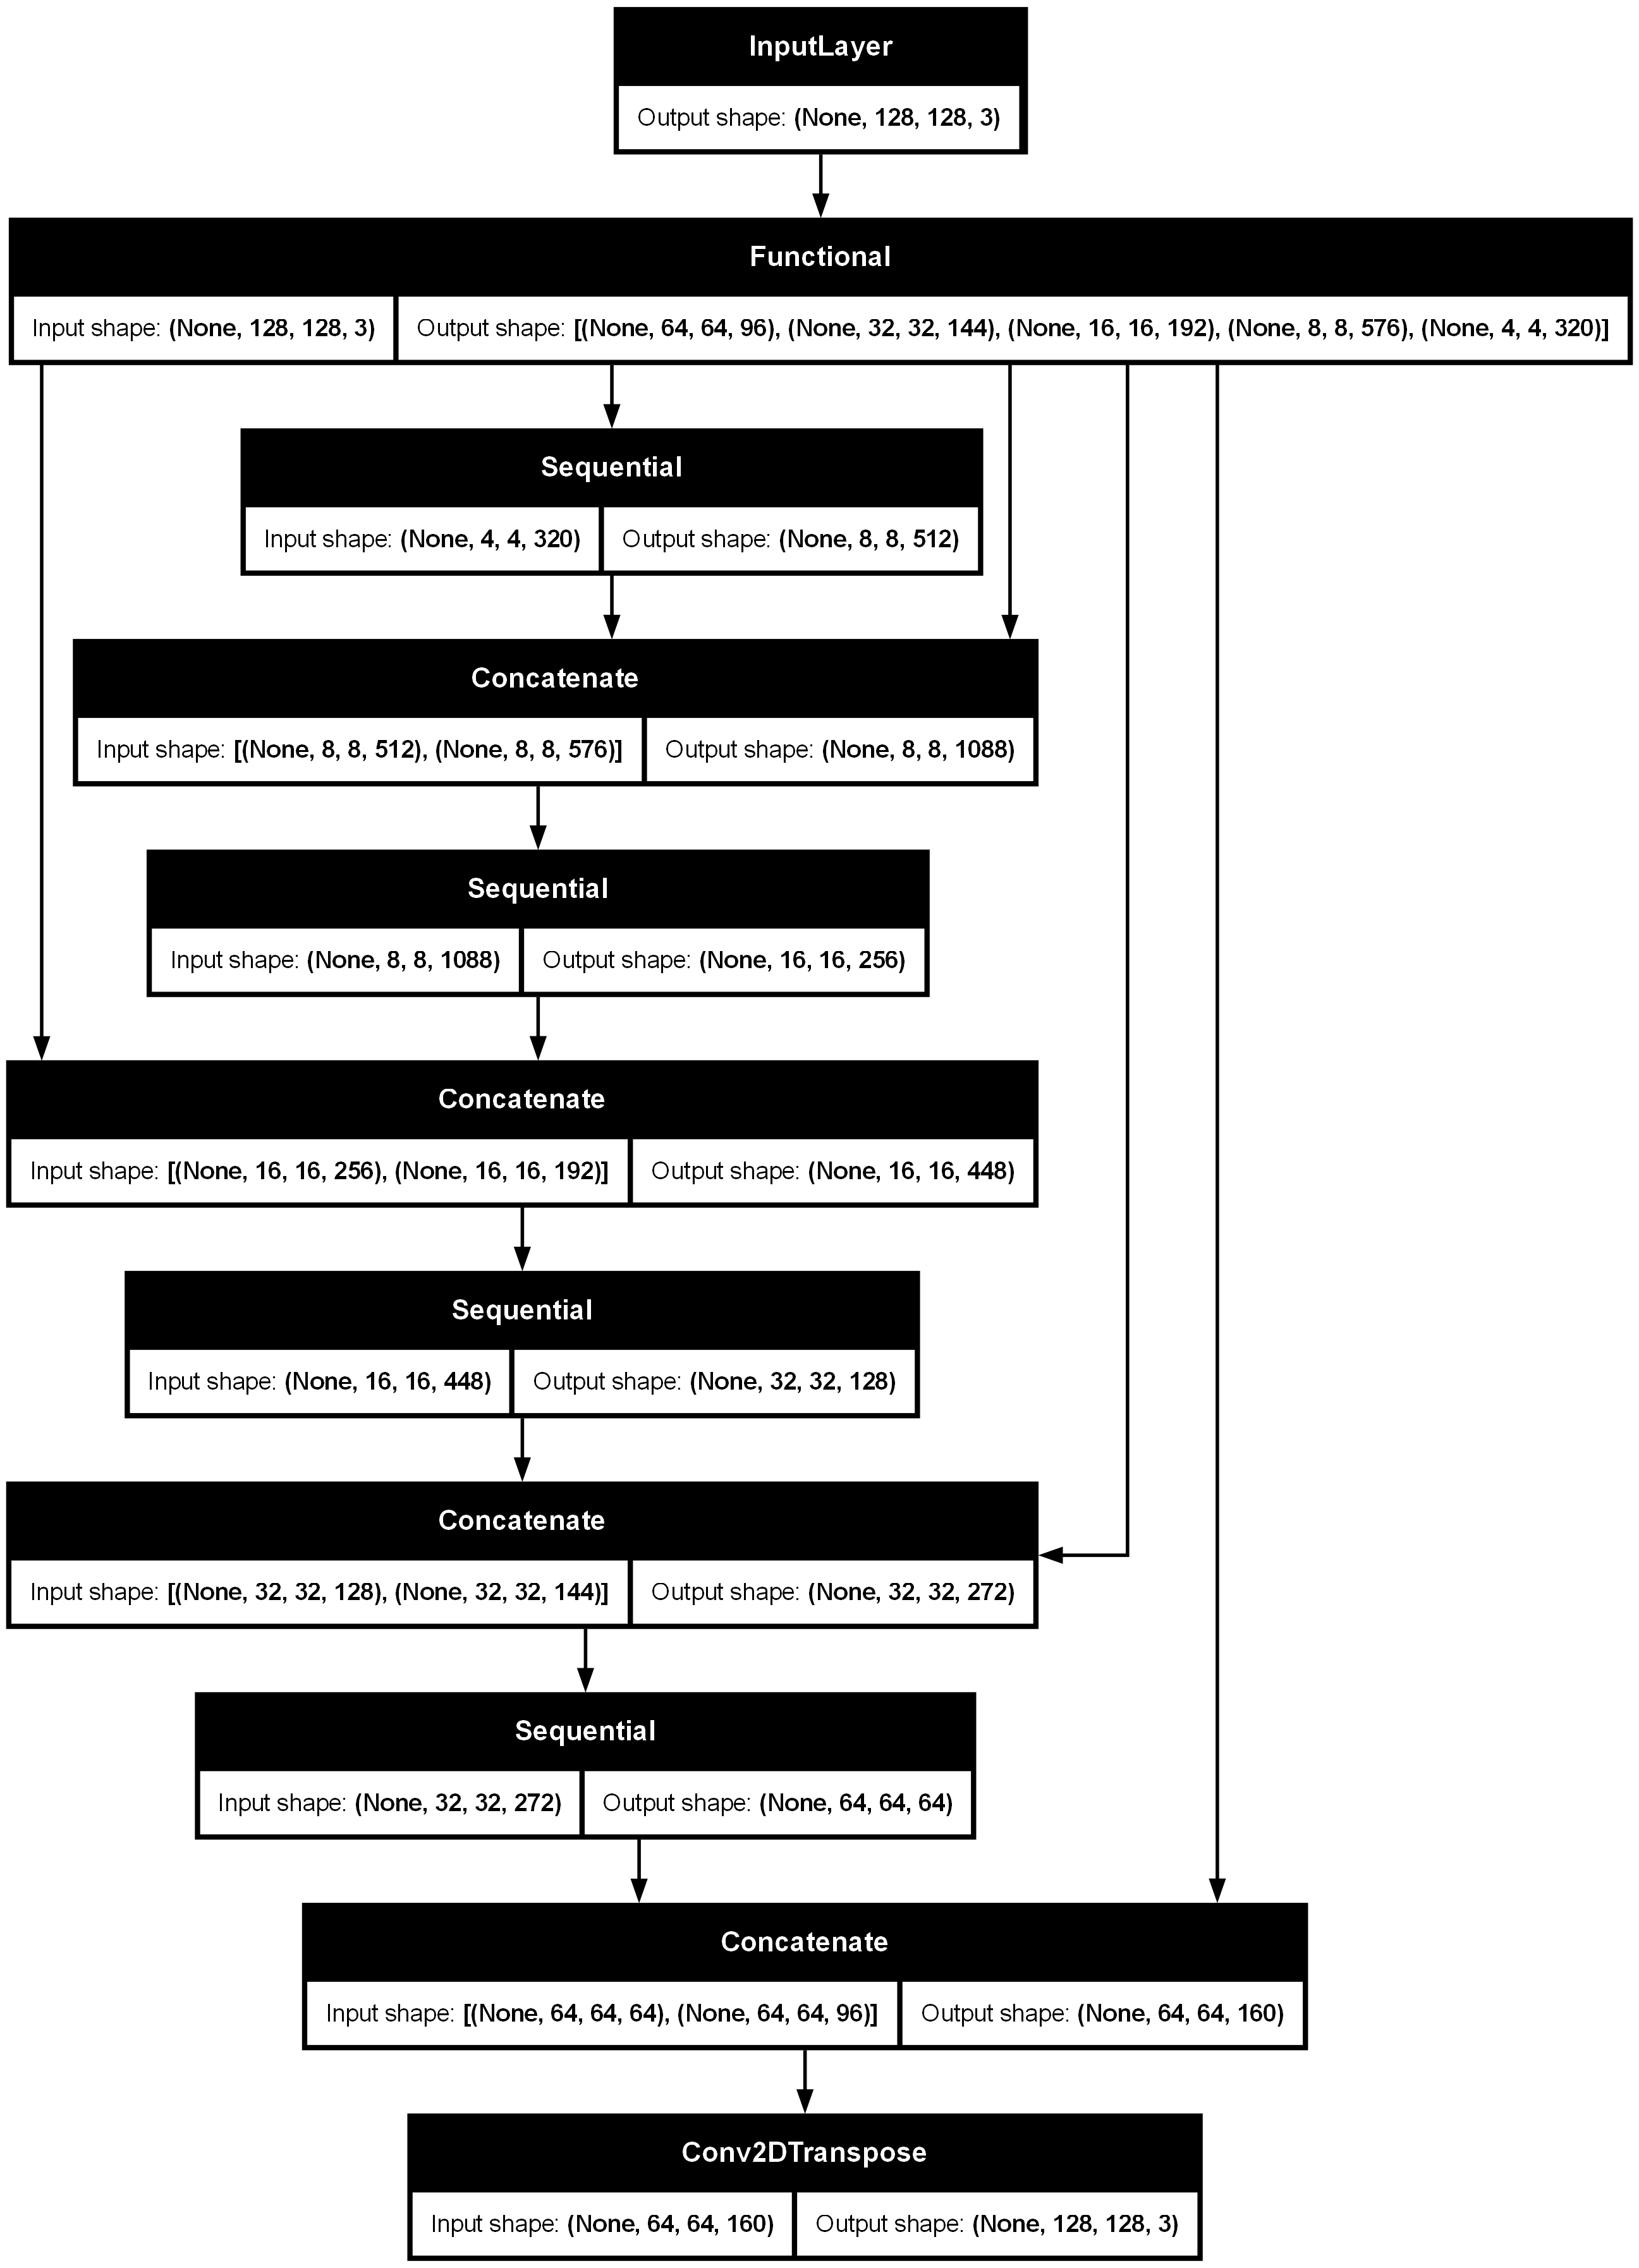

In [359]:
# 11. Use the function to create the U-Net model 
model = unet_model(3)
loss =  keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])
keras.utils.plot_model(model,show_shapes=True)  

In [360]:
# 12. Create callbacks functions
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [361]:
# Create the callbacks
import datetime,os
logpath = "tensorboard/biomedic/"+datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
es = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [362]:
# 13. Model training
EPOCHS = 50
VAL_SUBSPLITS = 5

history_first = model.fit(train_dataset, 
                          validation_data = test_dataset,
                          epochs=EPOCHS,
                          callbacks = [tb,es])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 593ms/step - accuracy: 0.5776 - loss: 0.9031 - val_accuracy: 0.8475 - val_loss: 0.3194
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 539ms/step - accuracy: 0.8802 - loss: 0.2281 - val_accuracy: 0.8543 - val_loss: 0.2414
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 524ms/step - accuracy: 0.9206 - loss: 0.1475 - val_accuracy: 0.8673 - val_loss: 0.2146
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 0.9305 - loss: 0.1249 - val_accuracy: 0.8643 - val_loss: 0.2171
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.9343 - loss: 0.1142 - val_accuracy: 0.8834 - val_loss: 0.1840
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 518ms/step - accuracy: 0.9371 - loss: 0.1080 - val_accuracy: 0.8991 - val_loss: 0.1593
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 518ms/step - accuracy: 0.9385 - loss: 0.1038 - val_accuracy: 0.9155 - val_loss: 0.1339
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.9405 - loss: 0.0997 - val_accu

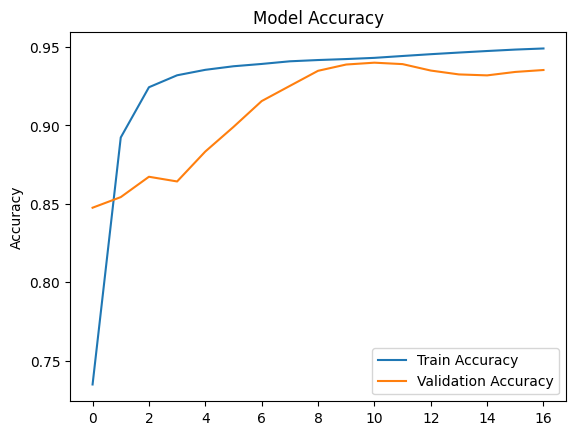

In [ ]:
# 14. Plot Accuracy Graph
plt.plot(history_first.history['accuracy'], label='Train Accuracy')
plt.plot(history_first.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.legend()  
plt.show()

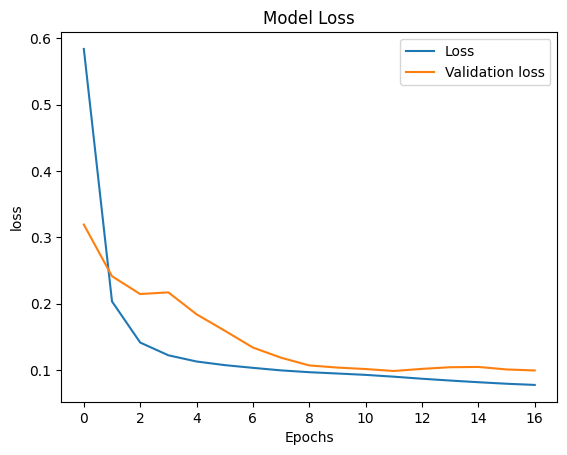

In [364]:
# Plot Loss Graph
plt.plot(history_first.history['loss'], label='Loss')
plt.plot(history_first.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


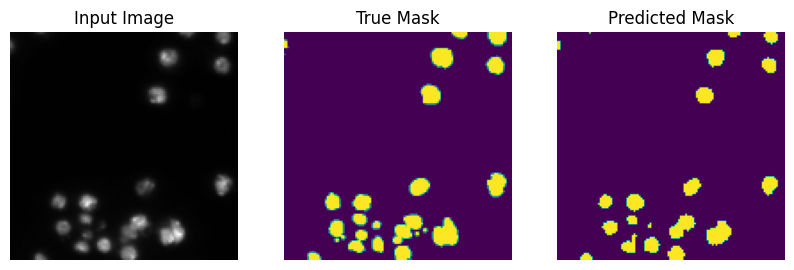

In [ ]:
# 15. Use model to make predictions
for test_img, test_label in test_dataset.take(1):
    predictions = model.predict(test_img)
    predictions = tf.math.argmax(predictions, axis=-1)
    predictions = tf.expand_dims(predictions, axis=-1) #expecting for 3D volume

# print(predictions[0].shape) #2D need to chanege to 3d volume
display([test_img[0], test_label[0], predictions[0]])

In [ ]:
# 15. Model Evaluation
evaluation = model.evaluate(test_dataset)
# The accuracy obtained is 94%

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9365 - loss: 0.0973


In [367]:
loss = evaluation[:1]
accuracy = evaluation[1:]
print("Loss is\n",loss)
print("Accuracy is\n",accuracy)

Loss is
 [0.09931141138076782]
Accuracy is
 [0.9353473782539368]


In [368]:
# SAVE THE MODEL 
keras.models.save_model(model,"models/nuclei_cell_analysis.h5")